In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb 10 06:02:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Libraries

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 164 µs (started: 2022-02-10 06:02:40 +00:00)


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 8.51 ms (started: 2022-02-10 06:02:40 +00:00)


In [ ]:
!pip install --quiet optuna

     |████████████████████████████████| 308 kB 7.2 MB/s 
     |████████████████████████████████| 80 kB 10.7 MB/s 
     |████████████████████████████████| 210 kB 51.3 MB/s 
     |████████████████████████████████| 75 kB 4.4 MB/s 
     |████████████████████████████████| 149 kB 73.1 MB/s 
     |████████████████████████████████| 113 kB 69.8 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
time: 5.73 s (started: 2022-02-10 06:02:40 +00:00)


In [ ]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm
import math 
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras import backend as K
import keras 
from keras.utils.layer_utils import count_params

import optuna # hyeperparam optimization 

time: 3.51 s (started: 2022-02-10 06:02:45 +00:00)


# Variables

## Paths

In [ ]:
root_dir ='/content/drive/MyDrive/@Projet datascientest/'
raw_data_dir = root_dir + 'RAW DATA/'
DL_dir = root_dir + 'DEEP LEARNING/' 

# export dir with time satmp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220210_06H02/
time: 325 ms (started: 2022-02-10 06:02:49 +00:00)


## Other

In [ ]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 15 # 5 pour convergence 1st step
# learing rate 
learning_rate =1e-4 #1e-4 
# batch size 
batch_size = 16 # 16
# base model trainable 
base_model_trainable = True

# number of trials optuna
n_trials = 25 

#ZIP file with images 
raw_data_folder = 'RAW DATA.zip'
# raw_data_folder = 'RAW DATA FOR DEBUG.zip' # pour aller plus vite sur unzip 1400 images only 
# df with file_path 
csv_file_paths = 'image_and_json_data_DEBUG.csv' if raw_data_folder == 'RAW DATA FOR DEBUG.zip' else 'image_and_json_data.csv'

# DEBUG 
debug = False
one_image_per_class_only = False  # HARD DEBUG TO SEE if CNN learn
# epochs
number_of_images = 1000 if debug else number_of_images
epochs = 2 if debug else epochs
family_number = 3 if debug else family_number 


time: 11.1 ms (started: 2022-02-10 06:02:49 +00:00)


# Load & filter data

## Unzip images

In [ ]:
# unzipping the file into the VM disk is SO much faster than reading each file individually from Drive
# cf https://stackoverflow.com/questions/59120853/google-colab-is-so-slow-while-reading-images-from-google-drive
main_path = "/content/"  + raw_data_folder.replace('.zip','') 
if os.path.exists(main_path)== False :
  if csv_file_paths == 'image_and_json_data_DEBUG.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA FOR DEBUG.zip' -d "/content"
  elif csv_file_paths == 'image_and_json_data.csv':
    !unzip '/content/drive/MyDrive/@Projet datascientest/RAW DATA.zip' -d "/content"
else:
  print('ZIP already extracted')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/618224.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619311.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/619904.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620199.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/620814.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/621320.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/622509.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/624754.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627015.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/627187.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune/629081.jpg  
  inflating: /content/RAW DATA/IMAGES/2016/Schizophyllum commune

In [ ]:
#FRUIT360 dataset pour créer un dataset sans champigons 
main_path = "/content/FRUIT360"
if os.path.exists(main_path)== False :
  if add_FRUIT360_images:
    !unzip '/content/drive/MyDrive/@Projet datascientest/FRUIT360.zip' -d "/content"

time: 2.36 ms (started: 2022-02-10 06:05:09 +00:00)


## File_path df

In [ ]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

215410 rows in the file


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6,9,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,date,thumbnail,location,gbif_info.kingdom,gbif_info.family,gbif_info.speciesKey,gbif_info.rank,gbif_info.phylum,gbif_info.orderKey,gbif_info.species,gbif_info.confidence,gbif_info.classKey,gbif_info.matchType,gbif_info.familyKey,gbif_info.status,gbif_info.usageKey,gbif_info.kingdomKey,gbif_info.genusKey,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(243, 320)",2006,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,2006-11-20 05:11:15,1,25.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
1,1604.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 164)",2006,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,2006-12-16 00:59:32,1,9.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
2,1608.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(320, 286)",2006,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,2006-12-16 01:25:12,1,55.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
3,29.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,2006-05-21 07:17:47,1,61.0,Fungi,NaN,NaN,ORDER,Basidiomycota,1499.0,NaN,96.0,186.0,EXACT,NaN,ACCEPTED,1499.0,5.0,NaN,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,observations_0.json
4,680.jpg,C:/Users/thibe/Google Drive/Projet datasciente...,"(240, 320)",2006,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,2006-05-21 07:34:55,1,1859.0,Fungi,Agaricaceae,NaN,GENUS,Basidiomycota,1499.0,NaN,92.0,186.0,EXACT,4170.0,ACCEPTED,7893259.0,5.0,7893259.0,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,observations_0.json


time: 2.83 s (started: 2022-02-10 06:05:09 +00:00)


In [ ]:
# FRUIT360
if add_FRUIT360_images:
  # Trouver tous les chemins vers les fichiers qui finissent par .jpg
  liste = glob.glob('/content/FRUIT360/*/*.jpg')
  # Remplacer les \\ par /
  liste = list(map(lambda x : [x, x.split('/')[2]], liste))
  # Créer un DataFrame pandas
  df_FRUIT360  = pd.DataFrame(liste, columns=['drive_file_path', 'gbif_info.family'])
  display(df_FRUIT360.head())

time: 2.29 ms (started: 2022-02-10 06:05:11 +00:00)


In [ ]:
# adjust paths for drive 
# SPECIFIC DRIVE lo laod image from content 
df_paths['drive_file_path'] =df_paths['file_path'].apply(lambda x: x.replace('C:/Users/thibe/Google Drive/@Projet datascientest',
                                              '/content')).apply(lambda x: x.replace('C:/Users/thibe/Google Drive/Projet datascientest',
                                              '/content')) # pas propre, remplacer par regex + re à l'occas 
df_paths['drive_file_path'] =df_paths['drive_file_path'].apply(lambda x: x.replace('\\','/'))
df_paths['drive_file_path']

0         /content/RAW DATA/IMAGES/2006/Agaricales/1208.jpg
1         /content/RAW DATA/IMAGES/2006/Agaricales/1604.jpg
2         /content/RAW DATA/IMAGES/2006/Agaricales/1608.jpg
3           /content/RAW DATA/IMAGES/2006/Agaricales/29.jpg
4            /content/RAW DATA/IMAGES/2006/Agaricus/680.jpg
                                ...                        
215405    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215406    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215407    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215408    /content/RAW DATA/IMAGES/2016/Xylocoremium fla...
215409    /content/RAW DATA/IMAGES/2016/Zygomycota/59276...
Name: drive_file_path, Length: 215410, dtype: object

time: 268 ms (started: 2022-02-10 06:05:11 +00:00)


In [ ]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 158 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 50.4 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 42.3 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    74497
Name: gbif_info.class, dtype: int64

time: 68.8 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5254
1,Albatrellaceae,204
2,Amanitaceae,4769
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,217
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,44


time: 24 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 25.2 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# ######### DEBUG LAST 3 FAMILLES TUOMR POUR INCLURE NO TUMOR ############
# # keep only top families 
# top_fam = df_paths['gbif_info.family'].value_counts().index.values[-3:]
# df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]
# #############################################

time: 1.03 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# reduce number or images if needed 
if number_of_images != None and not one_image_per_class_only: 
  df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
  print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 86.8 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
summary = df_paths.copy() #copy for later 
# summary.info()

time: 3.57 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# subset col of interest + label encoding
df = df_paths[['drive_file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,drive_file_path,gbif_info.family,label
44369,/content/RAW DATA/IMAGES/2010/Russula vinacea/...,Russulaceae,0
172598,/content/RAW DATA/IMAGES/2015/Lactarius delici...,Russulaceae,0
184582,/content/RAW DATA/IMAGES/2015/Tylopilus felleu...,Boletaceae,1
211179,/content/RAW DATA/IMAGES/2016/Russula parazure...,Russulaceae,0
63243,/content/RAW DATA/IMAGES/2011/Psilocybe cyanes...,Strophariaceae,2


time: 26 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# concat with FRUIT360 
if add_FRUIT360_images:
  df_FRUIT360['label'] = df['label'].max() + 1 
  df = pd.concat([df,df_FRUIT360]).reset_index(drop=True)

time: 1.18 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 5000


,label,gbif_info.family,size
0,0,Russulaceae,855
1,1,Boletaceae,847
2,2,Strophariaceae,628
3,3,Tricholomataceae,694
4,4,Amanitaceae,666
5,5,Agaricaceae,734
6,6,Cortinariaceae,576


time: 23.9 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Russulaceae',
 '1': 'Boletaceae',
 '2': 'Strophariaceae',
 '3': 'Tricholomataceae',
 '4': 'Amanitaceae',
 '5': 'Agaricaceae',
 '6': 'Cortinariaceae'}

time: 5.36 ms (started: 2022-02-10 06:05:12 +00:00)


## Train/test split

In [ ]:
#train/test 
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(4000, 3) (1000, 3)
time: 13.8 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 4.5 ms (started: 2022-02-10 06:05:12 +00:00)


### Plot few images

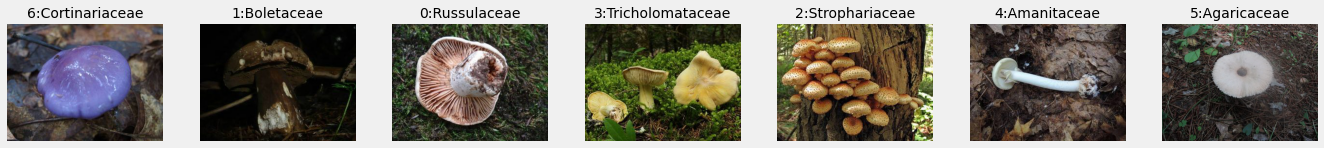

time: 580 ms (started: 2022-02-10 06:05:12 +00:00)


In [ ]:
# first od each cat to check train/test
im_to_plot = df_train.groupby('label').head(1)
# plot
fig = plt.figure(figsize=(3*family_number,2))
j = 1 
for idx in im_to_plot.index:
  col_number = family_number
  row_number = 1
  ax = plt.subplot(row_number,col_number,j)
  im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
  plt.imshow(im)
  label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
  plt.title(label,size = 14)
  plt.axis('off')
  j +=1
fig.savefig(export_dir + str(resol) + '_first image of each family.jpeg' );

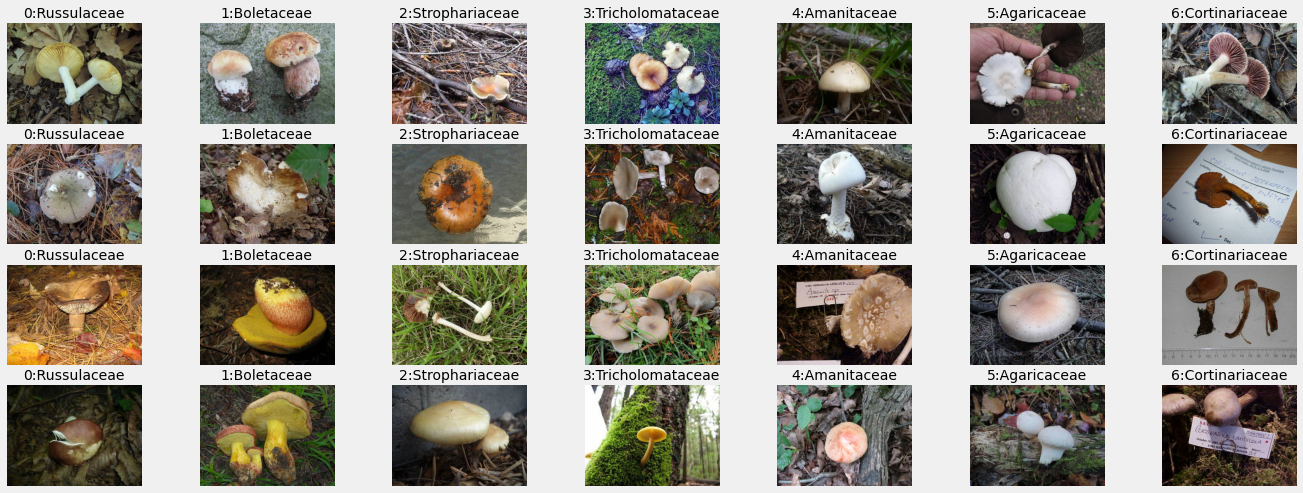

time: 1.67 s (started: 2022-02-10 06:05:13 +00:00)


In [ ]:
# Plot random images de X_train (im_per_class per class)
im_per_class = 5 
#generate df with n image per class train set 
dfs_ = []
for n in range(im_per_class-1):
  df_ = df_train.groupby('label').apply(lambda x: x.sample(1))
  df_ = df_.droplevel(level=0)
  dfs_.append(df_)
im_to_plot = pd.concat(dfs_)
# plot
fig = plt.figure(figsize=(3*family_number,2*im_per_class))
j = 1 
for idx in im_to_plot.index:
  try:
    col_number = family_number
    row_number = im_per_class
    ax = plt.subplot(row_number,col_number,j)
    im = io.imread(im_to_plot.loc[idx,'drive_file_path'])
    plt.imshow(im)
    label = str(im_to_plot.loc[idx,'label']) + ':' + dict_label[str(im_to_plot.loc[idx,'label'])]
    plt.title(label,size = 14)
    plt.axis('off')
  except:
    continue
  j +=1
fig.savefig(export_dir + str(resol) + '_family examples.jpeg' );

# Fonctions & Callbacks

In [ ]:
# model 
def define_model(model_name,base_model):
  base_model = base_model
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')
  dropout1 = tf.keras.layers.Dropout(0.3)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')
  dropout2 = tf.keras.layers.Dropout(0.5)
  prediction_layer =  Dense(units = classes_count, activation = 'softmax')


  for layer in base_model.layers:
      layer.trainable = base_model_trainable

  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense1, 
    dropout1,
    dense2,
    dropout2,
    prediction_layer
  ],
  name = model_name)
  return model



time: 11.2 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
def plot_history(history,pathinfos):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))

  plt.subplot(121)
  plt.plot(range(len(history['loss'])), history['loss'], '-o', label = "training")
  plt.plot(range(len(history['val_loss'])), history['val_loss'],  '-o',label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(range(len(history['accuracy'])), history['accuracy'], '-o', label = "training")
  plt.plot(range(len(history['val_accuracy'])), history['val_accuracy'], '-o', label = "validation")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 16.6 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
def plot_history_2steps(history,pathinfos,max_epoch_freeze=None):
  # train_acc_model = history['accuracy']
  # val_acc_model = history['val_accuracy']  

  fig = plt.figure(figsize=(20,5))
  
  x = np.arange(1,(len(history['loss']))+1,1)
  plt.subplot(121)
  plt.plot(x, history['loss'], '-o', label = "training")
  plt.plot(x, history['val_loss'],  '-o',label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("Fonction de perte en fonction de l'epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(x, history['accuracy'], '-o', label = "training")
  plt.plot(x, history['val_accuracy'], '-o', label = "validation")
  if max_epoch_freeze>0:
    plt.axvline(x=max_epoch_freeze, color = 'black' )
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.title("Accuracy en fonction de l'epoch")
  plt.legend();
  fig.suptitle(pathinfos + '_training history' ,size = 20 )
  fig.subplots_adjust(top=0.75)
  plt.close()
  return fig

time: 32.6 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(15,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')

  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1)


  # plt.show()
  plt.close()
  return fig

time: 34.4 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
def conf_matrix_and_clasif_report(y_test_class , test_pred_class,classes,df_label):
  ## Première étape, la matrice de confusion
  cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

  ### Display a nice confusion matrix
  classes = range(0,(classes))
  fig = plt.figure(figsize=(20,5))

  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')

  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.grid(False)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, format(cnf_matrix[i, j],'.1f'),
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels (%)')
  plt.xlabel('Labels prédits (%)')
  #add classif report 
  # plt.axvline(x=len(classes)+2, color = 'black')
  rep = metrics.classification_report(y_test_class, test_pred_class)
  plt.text(len(classes)+2.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+3, len(classes)-1, rep)
  #add label dict 
  lab_dict = 'label, family, count  \n\n '
  lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
  lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
  lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
  plt.text(len(classes)+11.5, len(classes)+1, '|\n'*20, va='bottom')
  plt.text(len(classes)+12, (len(classes)+2)/2, lab_dict)



  #TILTLE 
  title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
  plt.title(title, size=18,y=1.12,x=1.7,ha = 'center')


  # plt.show()
  plt.close()
  return fig

time: 53.4 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
# pour catcher la convergence lors de la première phase 
early_stopping_step1 = EarlyStopping(
                                patience=4, # Attendre 2 epochs avant application
                                min_delta = 0.02, # si au bout de 2 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

early_stopping_step2 = EarlyStopping(
                                patience=3, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 4 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=2, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.1,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 5.75 ms (started: 2022-02-10 06:05:15 +00:00)


# Training with Architecture EFB1 + FC 

## Dict of models 

In [ ]:
export_dir

'/content/drive/MyDrive/@Projet datascientest/DEEP LEARNING/220210_06H02/'

time: 2.3 ms (started: 2022-02-10 06:05:15 +00:00)


In [ ]:
model_dict = {
    'EFB1' : tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    # 'EFB0' : tf.keras.applications.EfficientNetB0(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
    # 'MobileNetV3Large': tf.keras.applications.MobileNetV3Large(input_shape=(resol[0], resol[1], 3),weights='imagenet',include_top=False),
}

27033600/27018416 [==============================] - 0s 0us/step
time: 5.63 s (started: 2022-02-10 06:05:15 +00:00)


## Choose model

In [ ]:
# define model 
model_name  = 'EFB1'
base_model = model_dict[model_name]
# csv start path infos 
pathinfos = model_name + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'

time: 1.5 ms (started: 2022-02-10 06:05:21 +00:00)


In [ ]:
# EN FIXANT architecture à 2 couches denses + 2 STEPS learning
#best architecture found using optuna cf cf trial 9 folder 220207_06H35 
trial_metric = {}
n_units_1, n_units_2 = 128,32
dropout_1, dropout_2 = 0.25 , 0.25 
lr = learning_rate # 1e-4 
batch_size = batch_size #16

time: 1.59 ms (started: 2022-02-10 06:05:21 +00:00)


## Train 1st step

In [ ]:
# GENERATOR
# Clear clutter from previous TensorFlow graphs.
tf.keras.backend.clear_session()
# split train/val 
df_train_, df_val_= train_test_split(df_train, train_size=0.8, stratify =df_train['label'], random_state=random_seed)
# train datagenerator
train_data_generator = ImageDataGenerator(
                                        #   rotation_range=0.1, #trial.suggest_discrete_uniform('rotation_range', 0.0,0.2,0.1),
                                        #   # # width_shift_range=trial.suggest_discrete_uniform('width_shift_range', 0.0, 0.2,0.1),
                                        #   # # height_shift_range=trial.suggest_discrete_uniform('height_shift_range', 0.0, 0.2,0.1),
                                        #   # # shear_range=trial.suggest_discrete_uniform('shear_range=', 0.0, 0.2,0.1),
                                        #   # zoom_range=trial.suggest_discrete_uniform('zoom_range', 0.0, 0.2,0.1),
                                        #   horizontal_flip= True, # trial.suggest_categorical("horizontal_flip", [True,False]),
                                        #   vertical_flip= True # trial.suggest_categorical("vertical_flip", [True,False]),
                                        #   # # fill_mode='nearest',
                                        ) 
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train_, 
                                                          x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#val datagenerator
val_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_val_,
                                                        x_col = "drive_file_path",y_col="label", 
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#test datagenerator w/o shuffle 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "drive_file_path",y_col="label",shuffle=False,
                                                        target_size=resol,batch_size=batch_size,class_mode='sparse')

Found 3200 validated image filenames belonging to 7 classes.
Found 800 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
time: 100 ms (started: 2022-02-10 06:05:21 +00:00)


In [42]:
def objective(trial):
  # trial param from https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=eqYT2OcmdnBu
  start_lr = trial.suggest_loguniform('start_lr',1e-4,1e-3) # 1E-5
  min_lr = trial.suggest_loguniform('min_lr',1e-7,1e-5) 
  max_lr = trial.suggest_loguniform('max_lr',5e-4,1e-3) 
  rampup_epochs = trial.suggest_discrete_uniform('rampup_epochs',0,10,1)
  sustain_epochs = trial.suggest_discrete_uniform('sustain_epochs',0,10,1)
  exp_decay = trial.suggest_discrete_uniform('exp_decay',0.1,0.8,0.1)
  text = 'trial ' + str(trial.number) + ':' + str(trial.params)
  print(text)
  # lr profile 
  def lrfn(epoch):
    if epoch < rampup_epochs:
      return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
      return max_lr
    else:
      return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
  lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
  rang = np.arange(20)
  y = [lrfn(x) for x in rang]
  plt.plot(rang, y)
  plt.show()
  print('Learning rate per epoch:')

  # base model layers 
  model_name  = 'EFB1'
  weights = 'imagenet' # trial.suggest_categorical("weights", [None,'imagenet'])
  base_model =  tf.keras.applications.EfficientNetB1(input_shape=(resol[0], resol[1], 3),
                                                      weights=weights,
                                                      include_top=False)
  # base_model =base_model 
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() 
  layers = [ base_model,  global_average_layer ]
  # define a number of classifier layers 
  layers.append(tf.keras.layers.Dense(units = n_units_1, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_1))
  layers.append(tf.keras.layers.Dense(units = n_units_2, activation = 'relu'))
  layers.append(tf.keras.layers.Dropout(dropout_2))
  # add predICTION layers 
  layers.append(Dense(units = classes_count, activation = 'softmax'))
  #freeze/unfreeze all layers 
  for layer in base_model.layers:
      layer.trainable = True # unfreeze at start   
  # build model        
  model = tf.keras.Sequential(layers,name = model_name)
  # optimizer 
  optimizer = "adam" #  trial.suggest_categorical("optimizer", ["sgd", "adam"]) 
  # compilation 
  model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
  K.set_value(model.optimizer.learning_rate, lr) #set learning rate 
  # csv start path infos 
  pathinfos = str(model.name) + '_' + str(resol) + '_' + str(family_number) + 'families_' + str(len(df_train)) + '_images'
  ## Entraînement
  model.summary()
  training_history_model_1 = model.fit(train_generator,epochs=epochs,
                                  steps_per_epoch = len(df_train_)//batch_size,
                                  validation_data = val_generator,validation_steps = len(df_val_)//batch_size,
                                    class_weight=class_weights,
                                  callbacks=[
                                              early_stopping_step1, # pas dans un premier temps on veut convergence 
                                              lr_callback 
                                              ],
                                  # use_multiprocessing = True,workers = 2 # pour warning tensorflow:Callback method on_train_batch_end is slow compared to the batch time
                                  ) 
  training_history_model_1 = training_history_model_1.history
  training_history_fig = plot_history(training_history_model_1,pathinfos)
  display(training_history_fig)
  return training_history_model_1['val_accuracy'][-1]

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize',
                            pruner=optuna.pruners.HyperbandPruner()
                            # pruner=optuna.pruners.MedianPruner( n_startup_trials=1 )
                            ) 
# initialisation avec un "good" set https://colab.research.google.com/notebooks/tpu.ipynb#scrollTo=7Qv8rC4aVOFB
study.enqueue_trial({"start_lr": 0.0002,
                     "min_lr": 0.00001,
                     "max_lr": 0.0005,
                    'rampup_epochs':4,
                     'sustain_epochs':0,
                    'exp_decay':0.8
                        })
study.optimize(objective, n_trials=n_trials,callbacks= [lambda study, trial: gc.collect(),
                                                        lambda study, trial: tf.keras.backend.clear_session()]) #cf https://stackoverflow.com/questions/64666917/optuna-memory-issues

Output hidden; open in https://colab.research.google.com to view.

In [44]:
trial_df = study.trials_dataframe()
display(trial_df)
trial_df.to_csv(export_dir + 'optuna_trials.csv')

,number,value,datetime_start,datetime_complete,duration,params_exp_decay,params_max_lr,params_min_lr,params_rampup_epochs,params_start_lr,params_sustain_epochs,system_attrs_fixed_params,state
0,0,0.51875,2022-02-10 06:16:34.275555,2022-02-10 06:22:53.224677,0 days 00:06:18.949122,0.8,0.000500,1.000000e-05,4.0,0.000200,0.0,"{'start_lr': 0.0002, 'min_lr': 1e-05, 'max_lr'...",COMPLETE
1,1,0.52500,2022-02-10 06:22:53.688043,2022-02-10 06:27:49.710565,0 days 00:04:56.022522,0.5,0.000515,8.360042e-07,5.0,0.000104,0.0,NaN,COMPLETE
2,2,0.51750,2022-02-10 06:27:50.171046,2022-02-10 06:34:30.152134,0 days 00:06:39.981088,0.7,0.000736,1.615327e-06,8.0,0.000161,0.0,NaN,COMPLETE
3,3,0.53625,2022-02-10 06:34:30.652559,2022-02-10 06:40:48.648431,0 days 00:06:17.995872,0.3,0.000507,6.503242e-06,10.0,0.000175,0.0,NaN,COMPLETE
4,4,0.53875,2022-02-10 06:40:49.145901,2022-02-10 06:46:43.915387,0 days 00:05:54.769486,0.2,0.000572,4.086869e-07,0.0,0.000816,5.0,NaN,COMPLETE
5,5,0.57500,2022-02-10 06:46:44.802207,2022-02-10 06:54:47.243429,0 days 00:08:02.441222,0.4,0.000671,8.996277e-06,9.0,0.000108,0.0,NaN,COMPLETE
6,6,0.46375,2022-02-10 06:54:48.147855,2022-02-10 07:05:12.006134,0 days 00:10:23.858279,0.8,0.000632,4.741301e-06,3.0,0.000333,6.0,NaN,COMPLETE
7,7,0.54875,2022-02-10 07:05:12.941482,2022-02-10 07:12:53.888755,0 days 00:07:40.947273,0.4,0.000683,6.056547e-06,10.0,0.000443,0.0,NaN,COMPLETE
8,8,0.56625,2022-02-10 07:12:54.837156,2022-02-10 07:19:35.124819,0 days 00:06:40.287663,0.5,0.000507,3.602689e-06,0.0,0.000409,4.0,NaN,COMPLETE
9,9,0.44750,2022-02-10 07:19:36.095473,2022-02-10 07:25:55.769166,0 days 00:06:19.673693,0.7,0.000660,2.740760e-06,3.0,0.000431,6.0,NaN,COMPLETE


time: 68.2 ms (started: 2022-02-10 09:28:37 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  """Entry point for launching an IPython kernel.


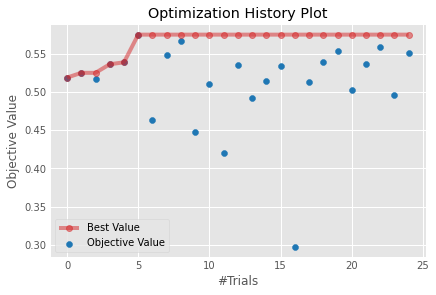

time: 302 ms (started: 2022-02-10 09:28:37 +00:00)


In [45]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.savefig(export_dir + pathinfos +  '_plot_optimization_history.jpeg',bbox_inches='tight'  )

In [46]:
fig = optuna.visualization.plot_intermediate_values(study)
plt.savefig(export_dir + pathinfos +  '_plot_intermediate_values.jpeg' )

[W 2022-02-10 09:28:38,300] You need to set up the pruning feature to utilize `plot_intermediate_values()`


<Figure size 432x288 with 0 Axes>

time: 113 ms (started: 2022-02-10 09:28:38 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



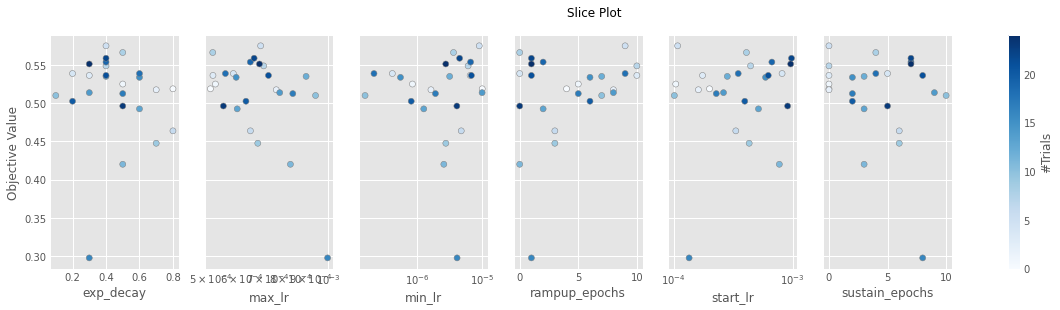

time: 2.07 s (started: 2022-02-10 09:28:38 +00:00)


In [47]:
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.savefig(export_dir + pathinfos +  '_plot_slice.jpeg',bbox_inches='tight' )

In [48]:
# optuna.visualization.plot_parallel_coordinate(study)

time: 789 µs (started: 2022-02-10 09:28:40 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



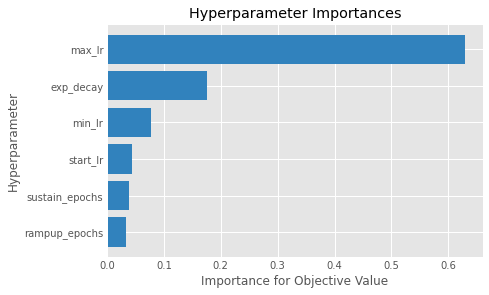

time: 705 ms (started: 2022-02-10 09:28:40 +00:00)


In [49]:
#Visualize parameter importances.
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.savefig(export_dir + pathinfos +  '_plot_param_importances.jpeg' ,bbox_inches='tight' )

In [50]:
print('Best trial is number {}: score {},\nparams {}'.format(study.best_trial.number,study.best_trial.value,study.best_trial.params))

Best trial is number 5: score 0.574999988079071,
params {'start_lr': 0.00010785251762989366, 'min_lr': 8.996276732614171e-06, 'max_lr': 0.0006714195737934243, 'rampup_epochs': 9.0, 'sustain_epochs': 0.0, 'exp_decay': 0.4}
time: 1.58 ms (started: 2022-02-10 09:28:41 +00:00)


In [51]:
study.best_trial.params

{'exp_decay': 0.4,
 'max_lr': 0.0006714195737934243,
 'min_lr': 8.996276732614171e-06,
 'rampup_epochs': 9.0,
 'start_lr': 0.00010785251762989366,
 'sustain_epochs': 0.0}

time: 8.68 ms (started: 2022-02-10 09:28:41 +00:00)


# Best trials

In [52]:
columns_name = ['accuracy','val_accuracy','test_accuracy','weighted_f1','fit_time']
trials_metric_df = pd.DataFrame.from_dict(trial_metric, orient='index', columns = columns_name)
trials_metric_df = trials_metric_df.sort_values(by='val_accuracy', ascending = False) 
trials_metric_df 

,accuracy,val_accuracy,test_accuracy,weighted_f1,fit_time


time: 12.7 ms (started: 2022-02-10 09:28:41 +00:00)


In [53]:
top3 = list(trials_metric_df.index[0:3])
# top3 = [trial_name.replace('_','') for trial_name in top3]


time: 999 µs (started: 2022-02-10 09:28:41 +00:00)


In [54]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  f = open(export_dir + pathinfos +  trial_infos  +  '_modelsummary.txt', "r")
  print(f.read())

time: 1.89 ms (started: 2022-02-10 09:28:41 +00:00)


In [55]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  training_history = Image.open(export_dir + pathinfos +  trial_infos  +  '_training_history.jpeg')
  display(training_history)

time: 1.81 ms (started: 2022-02-10 09:28:41 +00:00)


In [56]:
for trial_infos  in top3:
  print('_'*50+trial_infos+'_'*50)
  training_history = Image.open(export_dir + pathinfos +  trial_infos +  '_conf_matrix.jpeg' )
  display(training_history)

time: 1.93 ms (started: 2022-02-10 09:28:41 +00:00)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ExperimentalWarning:

plot_contour is experimental (supported from v2.2.0). The interface can change in the future.

[W 2022-02-10 09:29:12,804] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/usr/local/lib/python3.7/dist-packages/optuna/visualization/matplotlib/_contour.py:412: UserWarning:

No contour levels were found within the data range.



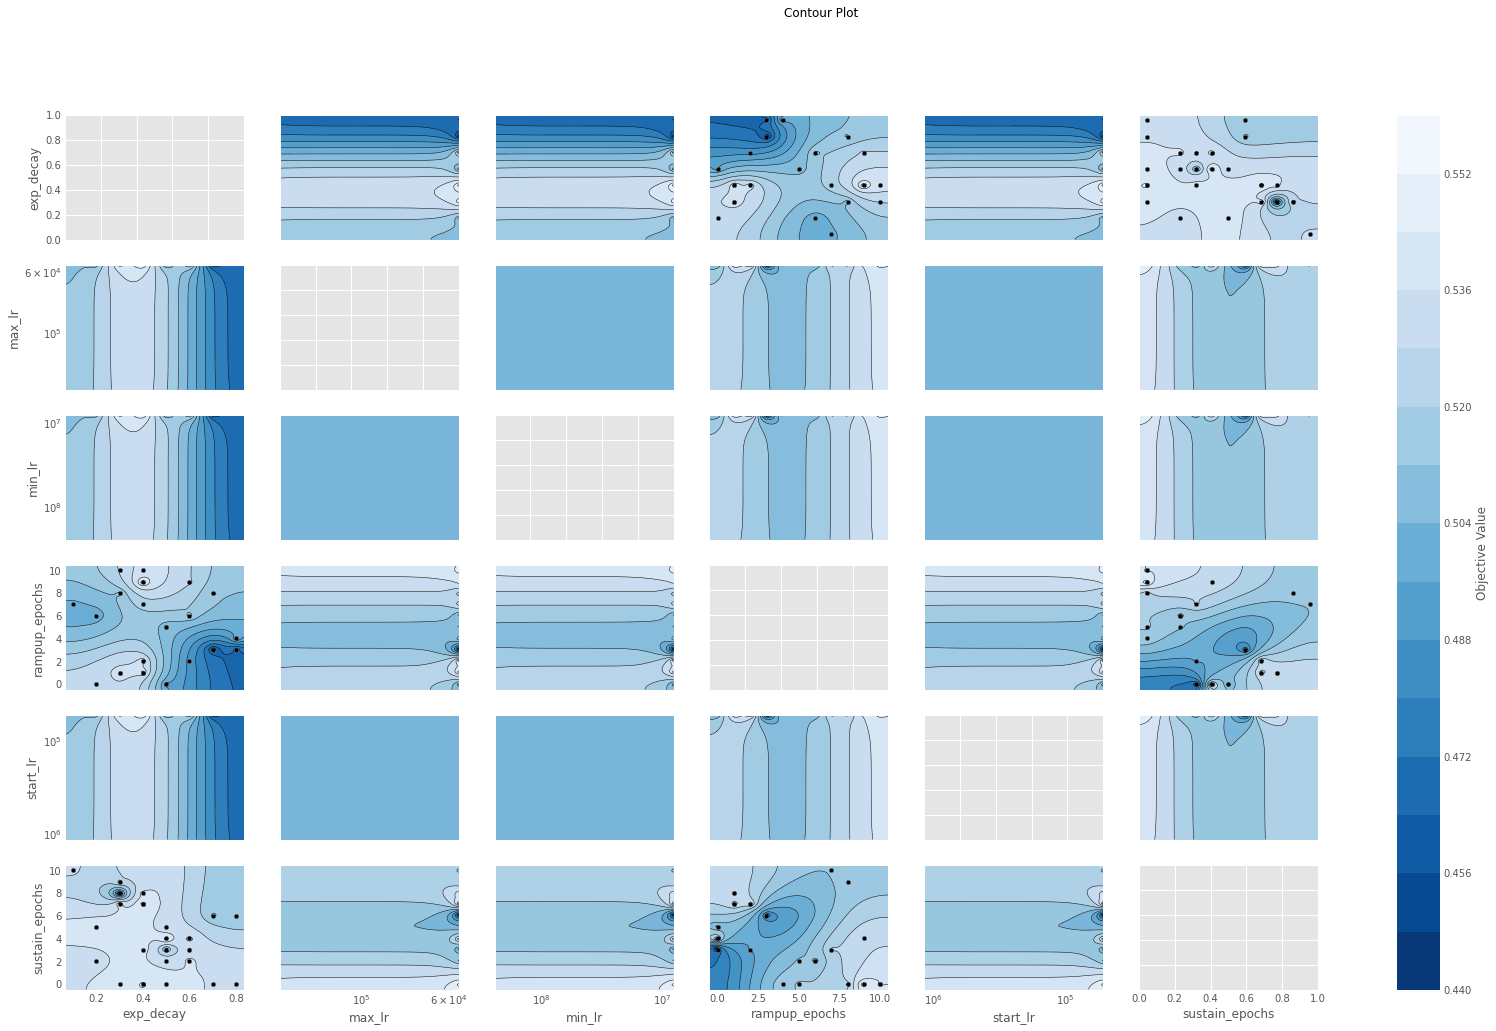

time: 1min 56s (started: 2022-02-10 09:29:12 +00:00)


In [58]:
# à la fin car very long 
from matplotlib import rcParams
rcParams['figure.figsize'] = 25,15
optuna.visualization.matplotlib.plot_contour(study) #DEBUG,['num_units_0','lr']
plt.savefig(export_dir + pathinfos +  '_plot_contour.jpeg' ,bbox_inches='tight' )
rcParams['figure.figsize'] = 6.4, 4.8 #reset to default 

# QUESTIONS 

- batch normalisation layers ? role , fonctionnement ? 
- Quand sont resettés les weigths in a for loop ? 
- use_multiprocessing = True,workers = 2

In [ ]:
# !kill -9 -1